# 04. PyTorch Custom Datasets

We've used some datasets with PyTorch before.

But how do you get your own data into PyTorch?

One of the ways to do so is via: custom datasets.

## Domain libraries

Depending on what you're working on, vision, text, audio, recommendation, you'll want to look into each of the PyTorch domain libraries for existing data loading functions and custom data loading functions.

## 0. Importing PyTorch and setting up device-agnostic code

In [2]:
import torch
from torch import nn

device = 'cuda' if torch.cuda.is_available() else 'cpu'
device

'cuda'

## 1. Get data

Our dataset is a subset of the FOod101 dataset.

Food 101 starts 101 different classes of food and 1000 images per class (750 training, 250 testing)

Our dataset starts with 3 classes of food and only 10% of the images (~75 training, 25 testing)

Why do this?

When starting out ML projects, it's important to try things on a small scale and then increase the scale when necessary.

The whole point is to speed up how fast you can experiment

In [12]:
import requests
import zipfile
from pathlib import Path

# Setup path to a data folder
data_path = Path('data/')
image_path = data_path / 'pizza_steak_sushi'

# If the image folder doesn't exist, download it and prepare it...
if image_path.is_dir():
    print(f"{image_path} directory already exists... skipping download")
else:
    print(f"{image_path} does not exist, creating one...")
    image_path.mkdir(parents=True, exist_ok=True)

# Download pizza, steak, sushi data
with open(data_path / 'pizza_steak_sushi.zip', 'wb') as f:
    request = requests.get("https://github.com/mrdbourke/pytorch-deep-learning/raw/refs/heads/main/data/pizza_steak_sushi.zip")
                            
    print(f"Downloading pizza, steak, sushi data...")
    f.write(request.content)

# Unzip pizza, steak, sushi data
with zipfile.ZipFile(data_path / "pizza_steak_sushi.zip", "r") as zip_ref:
    print("Unzipping pizza, steak and sushi data...")
    zip_ref.extractall(image_path)

data\pizza_steak_sushi directory already exists... skipping download
Unzipping pizza, steak and sushi data...


## 2. Becoming one with the data (data preparation and data exploration)

In [13]:
import os
def walk_through_dir(dir_path):
    """
    Walks through dir_path returning its contents.
    """
    for dirpath, dirnames, filenames in os.walk(dir_path):
        print(f"There are {len(dirnames)} directories and {len(filenames)} images in {dirpath}")

In [16]:
walk_through_dir(image_path)

There are 2 directories and 0 images in data\pizza_steak_sushi
There are 3 directories and 0 images in data\pizza_steak_sushi\test
There are 0 directories and 25 images in data\pizza_steak_sushi\test\pizza
There are 0 directories and 19 images in data\pizza_steak_sushi\test\steak
There are 0 directories and 31 images in data\pizza_steak_sushi\test\sushi
There are 3 directories and 0 images in data\pizza_steak_sushi\train
There are 0 directories and 78 images in data\pizza_steak_sushi\train\pizza
There are 0 directories and 75 images in data\pizza_steak_sushi\train\steak
There are 0 directories and 72 images in data\pizza_steak_sushi\train\sushi


In [17]:
# Setup train and testing paths
train_dir = image_path / "train"
test_dir = image_path / "test"

train_dir, test_dir

(WindowsPath('data/pizza_steak_sushi/train'),
 WindowsPath('data/pizza_steak_sushi/test'))

### 2.1 Visualizing an image

Let's write some code to:
1. Get all of the image paths
2. Pick a random image path using Python's random.choice()
3. Get the image class name using `pathlib.Path.parent.stem`
4. Since we're working with images, let's open the image with Python's PIL
5. We'll then show the image and print metadata

The image path: data\pizza_steak_sushi\train\pizza\667309.jpg
Class label: pizza
Image height: 384
Image width: 512


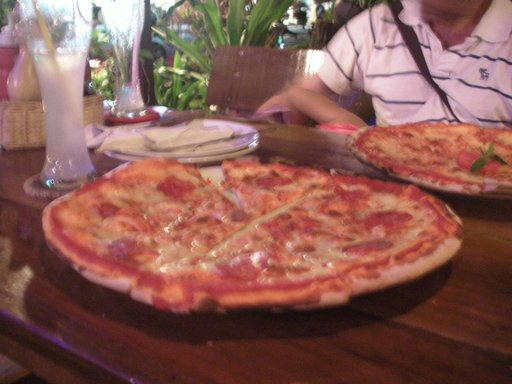

In [49]:
import random
from PIL import Image

# Set seed
# random.seed(42)

# 1. Get all image paths
image_path_list = list(image_path.glob("*/*/*.jpg"))

# 2. Pick a random image path
random_image_path = random.choice(image_path_list)
print(f"The image path: {random_image_path}")

# 3. Get image class from path name (the image class is the name of the directory where the image is stored)
image_class = random_image_path.parent.stem
print(f"Class label: {image_class}")

# 4. Open image
img = Image.open(random_image_path)

# 5. Print metadata
print(f"Image height: {img.height}")
print(f"Image width: {img.width}")
img

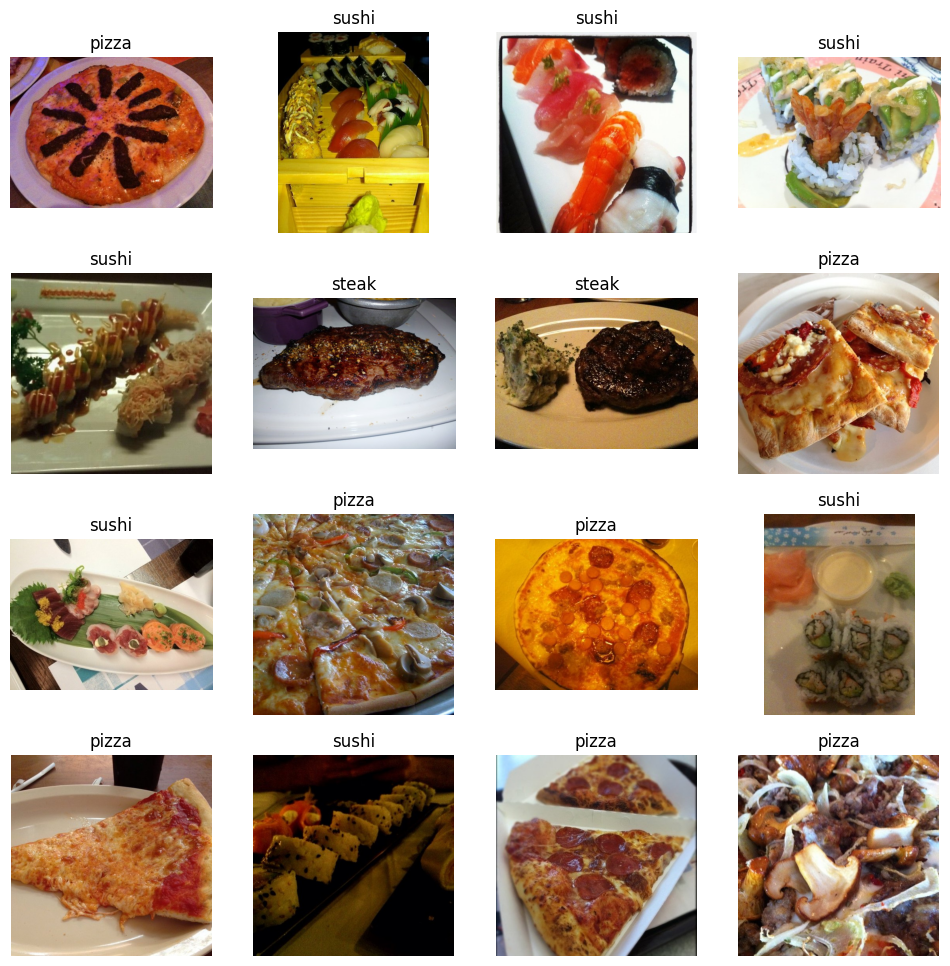

In [52]:
# Try to visualize an image with matplotlib by myself
import matplotlib.pyplot as plt
import numpy as np

# Get all image paths 
image_path_list = list(image_path.glob("train/*/*.jpg"))

nrows = 4
ncols = 4

plt.figure(figsize=(12, 12))
for i in range(1, nrows*ncols+1):
    random_image_path = random.choice(image_path_list)
    img = Image.open(random_image_path)

    plt.subplot(nrows, ncols, i)
    plt.imshow(img)
    plt.title(random_image_path.parent.stem)
    plt.axis(False)


(np.float64(-0.5), np.float64(511.5), np.float64(511.5), np.float64(-0.5))

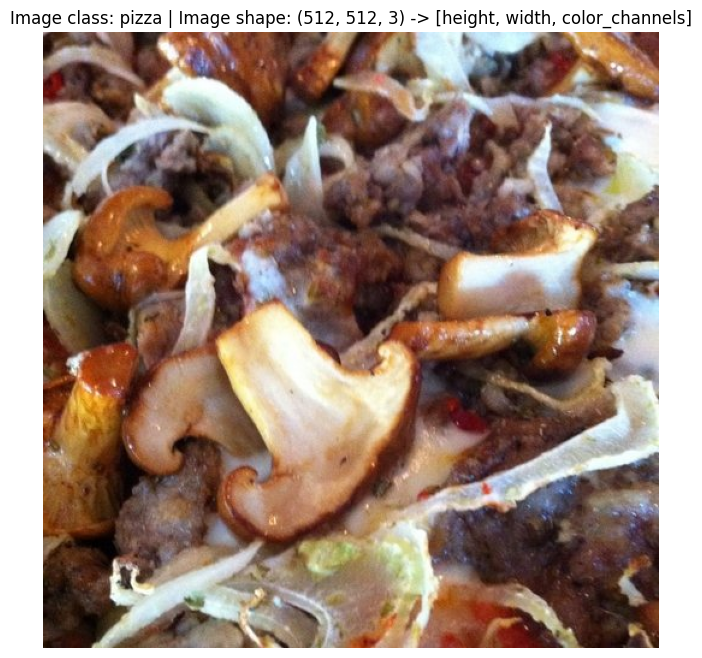

In [ ]:
# Turn the image into an array (this is the video's way of doing it)
img_as_array = np.asarray(img)

# Plot the image with matplotlib
plt.figure(figsize=(10, 8))
plt.imshow(img_as_array)
plt.title(f"Image class: {image_class} | Image shape: {img_as_array.shape} -> [height, width, color_channels]")
plt.axis(False)

In [56]:
img_as_array

array([[[172, 150, 152],
        [165, 143, 145],
        [150, 129, 128],
        ...,
        [106,  56,  45],
        [ 97,  47,  36],
        [ 91,  41,  30]],

       [[155, 133, 135],
        [138, 117, 116],
        [111,  90,  89],
        ...,
        [100,  50,  39],
        [ 94,  44,  35],
        [ 91,  41,  30]],

       [[117,  97,  96],
        [ 98,  78,  77],
        [ 71,  50,  49],
        ...,
        [ 96,  46,  37],
        [ 92,  42,  35],
        [ 92,  42,  33]],

       ...,

       [[ 30,  11,   0],
        [ 34,  17,   1],
        [ 32,  14,   0],
        ...,
        [ 51,  25,   8],
        [ 59,  33,  18],
        [ 60,  34,  21]],

       [[ 34,  16,   2],
        [ 38,  20,   6],
        [ 31,  13,   1],
        ...,
        [ 48,  22,   5],
        [ 53,  27,  12],
        [ 59,  36,  22]],

       [[ 48,  30,  16],
        [ 49,  31,  17],
        [ 36,  20,   7],
        ...,
        [ 55,  29,  12],
        [ 45,  22,   6],
        [ 49,  26,  12]]

## 3. Transforming data

Before we can use our image data with PyTorch:
1. Turn your target data into tensors (in our case, numerical representation of our images.)
2. Turn it into a `torch.utils.data.Datset` and subsequently a `torch.utils.data.DataLoader`, we'll call these `Dataset` and `DataLoader`

In [57]:
import torch
from torch.utils.data import DataLoader
from torchvision import datasets, transforms


### 3.1 Transforming data with `torchvision.transforms`

Transforms help you get your images ready to be used with a model/perform data augmentation

In [65]:
# Write a transform for an image
data_transform = transforms.Compose([
    # Resize our images to 64x64
    transforms.Resize(size=(64, 64)),
    # Flip the images randomly on the horizontal
    transforms.RandomHorizontalFlip(p=0.5),
    # Turn the image into a torch.Tensor
    transforms.ToTensor()
])

In [ ]:
# Turned our PIL image into a tensor
data_transform(img)

tensor([[[0.4196, 0.4235, 0.4275,  ..., 0.3922, 0.3020, 0.2353],
         [0.4039, 0.4196, 0.5412,  ..., 0.5529, 0.4353, 0.1843],
         [0.4471, 0.5686, 0.6706,  ..., 0.7020, 0.6471, 0.4078],
         ...,
         [0.3765, 0.3294, 0.4039,  ..., 0.2196, 0.1686, 0.1765],
         [0.3490, 0.4431, 0.4941,  ..., 0.1765, 0.2000, 0.2392],
         [0.3529, 0.4431, 0.2510,  ..., 0.1804, 0.1765, 0.1686]],

        [[0.2118, 0.2078, 0.2549,  ..., 0.2863, 0.1922, 0.1490],
         [0.1882, 0.2157, 0.3569,  ..., 0.4745, 0.3373, 0.1020],
         [0.2275, 0.3608, 0.4353,  ..., 0.6549, 0.5804, 0.3294],
         ...,
         [0.1765, 0.1725, 0.2902,  ..., 0.1412, 0.1059, 0.1137],
         [0.1843, 0.3020, 0.3765,  ..., 0.0902, 0.1216, 0.1608],
         [0.2314, 0.3216, 0.1608,  ..., 0.0667, 0.0863, 0.0902]],

        [[0.1961, 0.1961, 0.2431,  ..., 0.2118, 0.1216, 0.1216],
         [0.1686, 0.1804, 0.3294,  ..., 0.4196, 0.2863, 0.0706],
         [0.1843, 0.3098, 0.3137,  ..., 0.6549, 0.5490, 0.

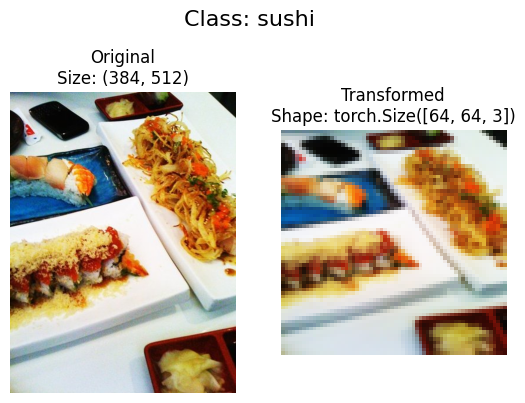

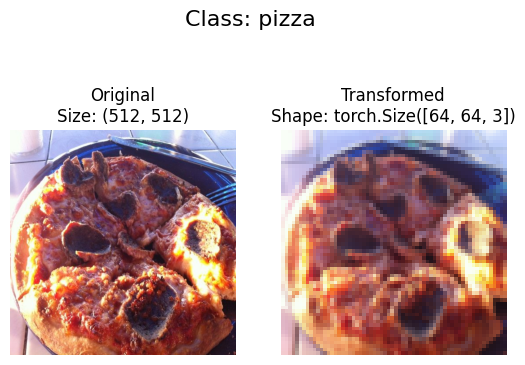

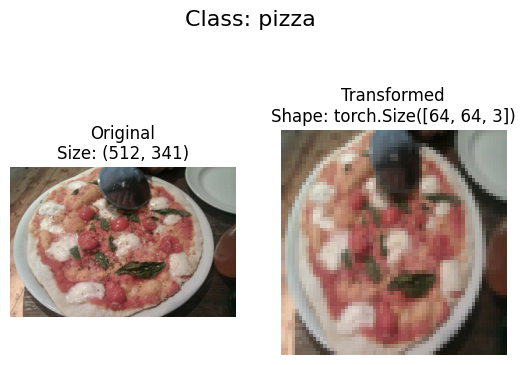

In [68]:
def plot_transformed_images(image_paths: list, transform, n=3, seed=None):
    """
    Selects random images from a path of images and loads/transforms 
    them the nplots the original vs the transformed version
    """
    if seed:
        random.seed(seed)
    
    random_image_paths = random.sample(image_paths, k=n)
    for image_path in random_image_paths:
        with Image.open(image_path) as f:
            fig, ax = plt.subplots(nrows=1, ncols=2)
            ax[0].imshow(f)
            ax[0].set_title(f"Original\nSize: {f.size}")
            ax[0].axis(False)

            # Transform and plot target image
            transformed_image = transform(f) # note we will need to change shape for matplotlib
            transformed_image = transformed_image.permute(1, 2, 0)
            ax[1].imshow(transformed_image)
            ax[1].set_title(f"Transformed\nShape: {transformed_image.shape}")
            ax[1].axis(False)

            fig.suptitle(f"Class: {image_path.parent.stem}", fontsize=16)

plot_transformed_images(image_paths=image_path_list,
                        transform=data_transform,
                        n=3,
                        seed=42)